In [1]:
# Get Credit Scoring Dataset
!python -m wget https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv


Saved under CreditScoring.csv


In [48]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# Read Dataset

df = pd.read_csv("CreditScoring.csv")

In [5]:
# View Data
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
# Clean Data
df.columns = df.columns.str.lower()

In [8]:
# Map Categorical Values from Numbers to Strings

status_values = {
    1: "ok",
    2: "default",
    3: "unk"
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
 
df.marital = df.marital.map(marital_values)
 
 
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
 
df.records = df.records.map(records_values)
 
 
job_values = {
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
 
df.job = df.job.map(job_values)


In [13]:
# Describe Data
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [12]:
# Replace Artificial Values w/ NaN
for c in ["income", "assets", "debt"]:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [15]:
# View Breakdown of Loan Status
df.status.value_counts()

ok         3200
default    1254
Name: status, dtype: int64

In [22]:
# Split Dataset for Training and Testing
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [23]:
# Declare Target Variables; Remove from Training and Validation Data
y_train = (df_train.status == "default").values
y_val = (df_val.status == "default").values

del df_train["status"]
del df_val["status"]

# Replace NaN Values with 0
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [25]:
# Perform One-Hot Encoding

# Convert Dataframes to Dicionaries
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [30]:
# Create Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [31]:
# Get ROC Score for Training Dataset
y_train_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_train_pred)

1.0

In [32]:
# Get ROC Score for Validation Dataset
y_test_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_test_pred)

0.6625112794966563

In [35]:
# dt Overfitted the Training Data -> Let's Make it More General By Reducing its Depth

dt2 = DecisionTreeClassifier(max_depth=2)
dt2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [37]:
# Display Both Trees

tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

tree_text_2 = export_text(dt2, feature_names=dv.feature_names_)
print(tree_text_2)

|--- records=yes <= 0.50
|   |--- job=parttime <= 0.50
|   |   |--- income <= 73.50
|   |   |   |--- expenses <= 71.00
|   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |--- time <= 30.00
|   |   |   |   |   |   |--- amount <= 295.00
|   |   |   |   |   |   |   |--- income <= 41.00
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- income >  41.00
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- amount >  295.00
|   |   |   |   |   |   |   |--- marital=separated <= 0.50
|   |   |   |   |   |   |   |   |--- price <= 1685.00
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- price >  1685.00
|   |   |   |   |   |   |   |   |   |--- assets <= 3750.00
|   |   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |   |--- assets >  3750.00
|   |   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- marital=separated >  0.50
|

In [38]:
# Evaluate dt2 ROC Score For Training Dataset

y_pred = dt2.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc', auc)

train auc 0.7017132266649385


In [39]:
# Evaluate dt2 ROC Score for Validation Dataset

y_pred = dt2.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('validation auc', auc)

validation auc 0.6876073869887143


In [45]:
# Perform Parameter Tuning to Determine Best Threshold for Tree Depth and Leaf Size

best_depth = 0
best_leaf_size = 0
best_roc_auc_score = 0

for m in [3, 4, 5, 6, 10, 15, 20, None]:
    print('depth: %s' % m)
 
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))

        if auc > best_roc_auc_score:
            best_depth = m
            best_leaf_size = s
            best_roc_auc_score = auc
   
    print()

tuned_dt = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_leaf_size)

depth: 3
1 -> 0.763
5 -> 0.763
10 -> 0.763
15 -> 0.763
20 -> 0.763
50 -> 0.765
100 -> 0.756
200 -> 0.753

depth: 4
1 -> 0.779
5 -> 0.779
10 -> 0.774
15 -> 0.771
20 -> 0.784
50 -> 0.778
100 -> 0.767
200 -> 0.765

depth: 5
1 -> 0.784
5 -> 0.787
10 -> 0.783
15 -> 0.780
20 -> 0.785
50 -> 0.789
100 -> 0.786
200 -> 0.778

depth: 6
1 -> 0.773
5 -> 0.786
10 -> 0.791
15 -> 0.795
20 -> 0.802
50 -> 0.793
100 -> 0.793
200 -> 0.789

depth: 10
1 -> 0.721
5 -> 0.743
10 -> 0.776
15 -> 0.793
20 -> 0.801
50 -> 0.797
100 -> 0.794
200 -> 0.789

depth: 15
1 -> 0.670
5 -> 0.744
10 -> 0.766
15 -> 0.787
20 -> 0.799
50 -> 0.797
100 -> 0.794
200 -> 0.789

depth: 20
1 -> 0.679
5 -> 0.749
10 -> 0.765
15 -> 0.786
20 -> 0.802
50 -> 0.797
100 -> 0.794
200 -> 0.789

depth: None
1 -> 0.664
5 -> 0.749
10 -> 0.765
15 -> 0.786
20 -> 0.802
50 -> 0.797
100 -> 0.794
200 -> 0.789



In [53]:
# Train Final Model

final_dt = tuned_dt

final_dt.fit(X_train, y_train)

final_y_pred = final_dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, final_y_pred)

print(f"Best Decision Tree Validation ROC AUC Score: {auc}")

Best Decision Tree Validation ROC AUC Score: 0.7999079098629154


In [55]:
# Create and Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8020803718216541

10 -> 0.802
20 -> 0.826
30 -> 0.826
40 -> 0.827
50 -> 0.832
60 -> 0.832
70 -> 0.830
80 -> 0.832
90 -> 0.832
100 -> 0.829
110 -> 0.830
120 -> 0.831
130 -> 0.832
140 -> 0.833
150 -> 0.834
160 -> 0.834
170 -> 0.833
180 -> 0.833
190 -> 0.834
200 -> 0.834


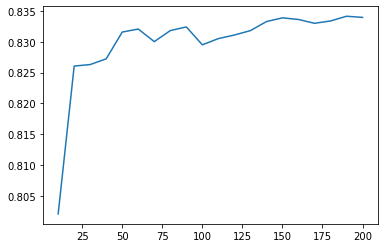

In [56]:
# Determine Optimal Ensemble

best_n_esimtators = 0
best_roc_auc_score = 0
aucs = []
 
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
 
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    if auc > best_roc_auc_score:
        best_n_esimtators = i
        best_roc_auc_score = auc

    print('%s -> %.3f' % (i, auc))
 
    aucs.append(auc)

tuned_rf = RandomForestClassifier(n_estimators=best_n_esimtators, random_state=3)

# Plot Result of Varying Estimators
plt.plot(range(10, 201, 10), aucs)